# 1- Segmentation Image
#### Objectif : segmenter chaque image en **3 classes** (par pixel) à partir des trimaps :

- **0 : Animal (foreground)**
- **1 : Fond (background)**
- **2 : Bordure (border)**

In [50]:
import os
import json
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image

## Chemin racine de mon projet (données + modèle)

In [4]:
ROOT_DIR = '/home/el-morady/Téléchargements/HDDL_fv'

IMAGE_DIR = os.path.join(ROOT_DIR, 'images') 
ANNOTATION_FILE = os.path.join(ROOT_DIR, 'annotations', 'list_of_files.txt')

print(f"Le répertoire des images est: {IMAGE_DIR}")
print(f"Le fichier d'annotation est: {ANNOTATION_FILE}")

Le répertoire des images est: /home/el-morady/Téléchargements/HDDL_fv/images
Le fichier d'annotation est: /home/el-morady/Téléchargements/HDDL_fv/annotations/list_of_files.txt


## Préparation des données:

On crée un Dataset qui charge l'image RGB et le trimap correspondant.

In [5]:
class OxfordSegmentationDataset(Dataset):
    def __init__(self, root_dir, split="trainval", target_size=(256, 256)):
        self.root_dir = root_dir
        self.target_size = target_size
        
        # Chemins vers les dossiers 
        self.images_dir = os.path.join(self.root_dir, 'images')   
        self.masks_dir  = os.path.join(self.root_dir, 'annotations', 'trimaps')

        # Lecture du fichier liste
        list_filename   = "list.txt" if split == "trainval" else "test.txt"
        list_file_path  = os.path.join(self.root_dir, 'annotations', list_filename)

        self.data_list = []
        
        with open(list_file_path, 'r') as f:
            for line in f:
                if line.strip() and not line.startswith('#'):
                    parts = line.split()
                    filename_no_ext = parts[0]
                    self.data_list.append(filename_no_ext)

        print(f"Dataset {split} chargé : {len(self.data_list)} images.")

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        filename = self.data_list[idx]

        # 1. Construction des chemins
        img_path  = os.path.join(self.images_dir, filename + ".jpg")
        mask_path = os.path.join(self.masks_dir,  filename + ".png")

        # 2. Chargement image + masque
        image = Image.open(img_path).convert("RGB")
        mask  = Image.open(mask_path) 

        # 3. Redimensionnement
        image = image.resize(self.target_size, Image.BILINEAR)
        mask  = mask.resize(self.target_size, Image.NEAREST)

        # 4. Transform image en tenseur normalisé
        img_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        image_tensor = img_transform(image)

        mask_np = np.array(mask, dtype=np.int64)  

        mask_np = mask_np - 1   
        
        mask_tensor = torch.as_tensor(mask_np, dtype=torch.long)

        return image_tensor, mask_tensor, filename

## Définition du train, validation et test datasets:

In [6]:
trainval_dataset = OxfordSegmentationDataset(ROOT_DIR, split="trainval", target_size=(256,256))
test_dataset     = OxfordSegmentationDataset(ROOT_DIR, split="test",     target_size=(256,256))

val_ratio = 0.10
n_total = len(trainval_dataset)
n_val   = int(val_ratio * n_total)
n_train = n_total - n_val

g = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(trainval_dataset, [n_train, n_val], generator=g)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,  num_workers=0, pin_memory=False)
val_loader   = DataLoader(val_dataset,   batch_size=16, shuffle=False, num_workers=0, pin_memory=False)
test_loader  = DataLoader(test_dataset,  batch_size=16, shuffle=False, num_workers=0, pin_memory=False)

Dataset trainval chargé : 7349 images.
Dataset test chargé : 3669 images.


## U-Net (from scratch)
Architecture U-Net classique : encoder + decoder + skip connections.

In [7]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, mid_ch=None):
        super().__init__()
        if mid_ch is None:
            mid_ch = out_ch
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, mid_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(mid_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )

    def forward(self, x):
        return self.net(x)

class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_ch, out_ch, mid_ch=in_ch//2)
        else:
            self.up = nn.ConvTranspose2d(in_ch, in_ch//2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size(2) - x1.size(2)
        diffX = x2.size(3) - x1.size(3)
        x1 = F.pad(x1, [diffX//2, diffX - diffX//2,
                        diffY//2, diffY - diffY//2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=3, bilinear=False):
        super().__init__()
        self.inc   = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)

        self.up1 = Up(1024, 512 // factor, bilinear=bilinear)
        self.up2 = Up(512, 256 // factor, bilinear=bilinear)
        self.up3 = Up(256, 128 // factor, bilinear=bilinear)
        self.up4 = Up(128, 64, bilinear=bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x,  x3)
        x = self.up3(x,  x2)
        x = self.up4(x,  x1)
        return self.outc(x)

## Métriques (Dice / IoU) en multi-classe

In [8]:
def calculate_metrics_multiclass(pred_mask, true_mask, num_classes=3, ignore_index=None, eps=1e-6):
    
    dice_pc = [0.0] * num_classes
    iou_pc  = [0.0] * num_classes

    used = []
    for c in range(num_classes):
        if ignore_index is not None and c == ignore_index:
            continue
        pred_c   = (pred_mask == c).float()
        target_c = (true_mask == c).float()

        inter = (pred_c * target_c).sum()
        union = pred_c.sum() + target_c.sum() - inter

        dice = (2*inter + eps) / (pred_c.sum() + target_c.sum() + eps)
        iou  = (inter + eps) / (union + eps)

        dice_pc[c] = dice.item()
        iou_pc[c]  = iou.item()
        used.append(c)

    dice_mean = float(np.mean([dice_pc[c] for c in used])) if used else 0.0
    iou_mean  = float(np.mean([iou_pc[c]  for c in used])) if used else 0.0
    return dice_pc, iou_pc, dice_mean, iou_mean

## Entraînement + validation
Loss = `CrossEntropyLoss`.

On suit `train_loss`, `val_loss`, `val_dice`, `val_iou`.

On sauvegarde le meilleur checkpoint selon le Dice sur validation.

In [23]:
def evaluate_epoch(model, loader, device, num_classes=3, ignore_index=None):
    model.eval()
    loss_sum = 0.0
    dice_sum = 0.0
    iou_sum  = 0.0
    n_batches = 0

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for images, masks, _names in loader:
            images = images.to(device)
            masks  = masks.to(device).long()

            logits = model(images)
            loss = criterion(logits, masks)

            preds = torch.argmax(logits, dim=1)
            _, _, dice_mean, iou_mean = calculate_metrics_multiclass(
                preds, masks, num_classes=num_classes, ignore_index=ignore_index
            )

            loss_sum += loss.item()
            dice_sum += dice_mean
            iou_sum  += iou_mean
            n_batches += 1

    return (loss_sum / n_batches, dice_sum / n_batches, iou_sum / n_batches)


def train_segmentation(model, train_loader, val_loader, device,
                       num_epochs=10, lr=1e-4, num_classes=3, ignore_index=None,
                       save_path="best_unet_segmentation.pth"):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    history = {"train_loss": [], "val_loss": [], "val_dice": [], "val_iou": []}
    best_dice = -1.0

    for epoch in range(1, num_epochs + 1):
        model.train()
        running = 0.0
        n_batches = 0

        for images, masks, _names in train_loader:
            images = images.to(device)
            masks  = masks.to(device).long()

            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, masks)
            loss.backward()
            optimizer.step()

            running += loss.item()
            n_batches += 1

        train_loss = running / n_batches
        val_loss, val_dice, val_iou = evaluate_epoch(
            model, val_loader, device, num_classes=num_classes, ignore_index=ignore_index
        )

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_dice"].append(val_dice)
        history["val_iou"].append(val_iou)

        print(f"Epoch {epoch:02d}/{num_epochs} | "
              f"Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f} | "
              f"Val Dice: {val_dice:.4f} | Val IoU: {val_iou:.4f}")

        if val_dice > best_dice:
            best_dice = val_dice
            torch.save(model.state_dict(), save_path)

    print(f"Meilleur modèle sauvegardé avec Val Dice = {best_dice:.4f} -> {save_path}")
    return history

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_channels=3, n_classes=3).to(device)

history = train_segmentation(
    model,
    train_loader,
    val_loader,
    device,
    num_epochs=10,
    lr=1e-4,
    num_classes=3,
    ignore_index=None,
    save_path=os.path.join(ROOT_DIR, "best_unet_segmentation.pth")
)

Epoch 01/10 | Train loss: 0.5917 | Val loss: 0.4400 | Val Dice: 0.7635 | Val IoU: 0.6377
Epoch 02/10 | Train loss: 0.3941 | Val loss: 0.3620 | Val Dice: 0.7866 | Val IoU: 0.6692
Epoch 03/10 | Train loss: 0.3418 | Val loss: 0.3339 | Val Dice: 0.8031 | Val IoU: 0.6915
Epoch 04/10 | Train loss: 0.3093 | Val loss: 0.3193 | Val Dice: 0.8064 | Val IoU: 0.6966
Epoch 05/10 | Train loss: 0.2886 | Val loss: 0.2958 | Val Dice: 0.8203 | Val IoU: 0.7137
Epoch 06/10 | Train loss: 0.2654 | Val loss: 0.2911 | Val Dice: 0.8243 | Val IoU: 0.7196
Epoch 07/10 | Train loss: 0.2526 | Val loss: 0.2644 | Val Dice: 0.8353 | Val IoU: 0.7355
Epoch 08/10 | Train loss: 0.2338 | Val loss: 0.3058 | Val Dice: 0.8184 | Val IoU: 0.7112
Epoch 09/10 | Train loss: 0.2231 | Val loss: 0.2528 | Val Dice: 0.8434 | Val IoU: 0.7466
Epoch 10/10 | Train loss: 0.2081 | Val loss: 0.2817 | Val Dice: 0.8366 | Val IoU: 0.7359
Meilleur modèle sauvegardé avec Val Dice = 0.8434 -> /home/el-morady/Téléchargements/HDDL_fv/best_unet_segment

In [35]:
history_path = os.path.join(ROOT_DIR, "history_segmentation.json")
with open(history_path, "w") as f:
    json.dump(history, f, indent=2)

print("History sauvegardé ->", history_path)

History sauvegardé -> /home/el-morady/Téléchargements/HDDL_fv/history_segmentation.json


In [12]:
history_path = os.path.join(ROOT_DIR, "history_segmentation.json")

with open(history_path, "r") as f:
    history = json.load(f)

## Courbes d'apprentissage
On trace loss et métriques de validation.

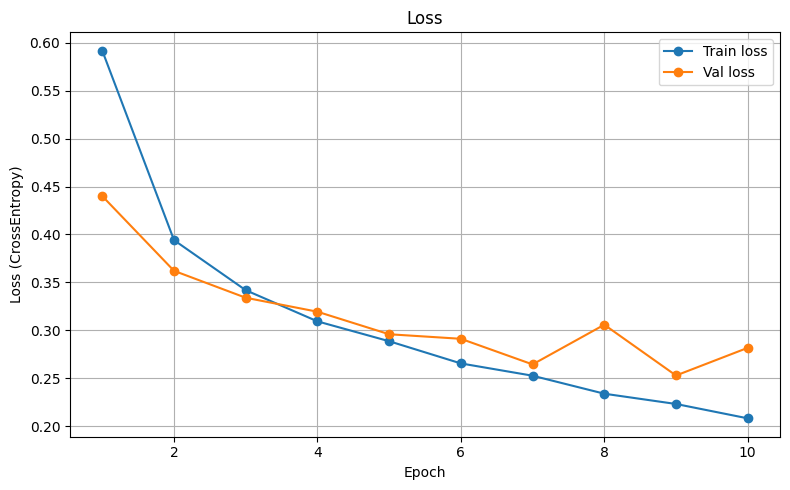

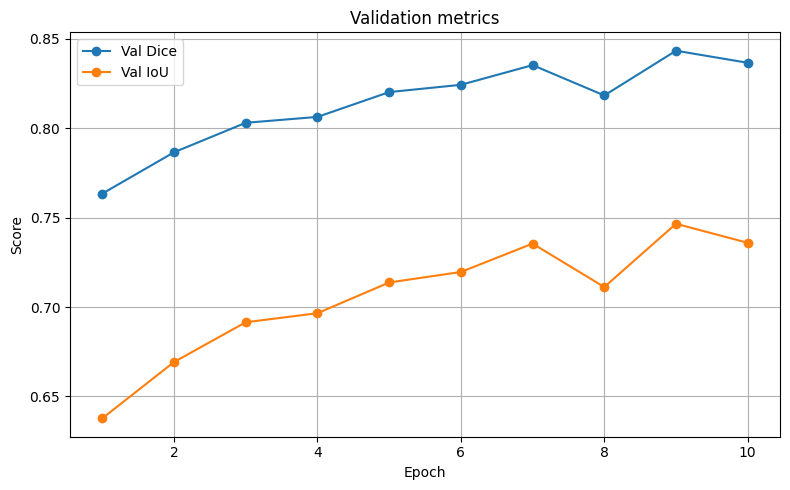

In [13]:
def plot_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(8,5))
    plt.plot(epochs, history["train_loss"], marker="o", label="Train loss")
    plt.plot(epochs, history["val_loss"], marker="o", label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (CrossEntropy)")
    plt.title("Loss")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,5))
    plt.plot(epochs, history["val_dice"], marker="o", label="Val Dice")
    plt.plot(epochs, history["val_iou"], marker="o", label="Val IoU")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title("Validation metrics")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_history(history)

## Évaluation finale sur le test
On recharge le meilleur checkpoint et on calcule Dice/IoU par classe + moyenne.

In [14]:
@torch.no_grad()
def evaluate_model(model, loader, device, num_classes=3, ignore_index=None):
    model.eval()

    dice_sum = [0.0] * num_classes
    iou_sum  = [0.0] * num_classes
    counts   = [0]   * num_classes

    dice_mean_sum = 0.0
    iou_mean_sum  = 0.0
    n_batches = 0

    for images, masks, _names in loader:
        images = images.to(device)
        masks  = masks.to(device).long()

        logits = model(images)
        preds  = torch.argmax(logits, dim=1)

        dice_pc, iou_pc, dice_mean, iou_mean = calculate_metrics_multiclass(
            preds, masks, num_classes=num_classes, ignore_index=ignore_index
        )

        for c in range(num_classes):
            if ignore_index is not None and c == ignore_index:
                continue
            dice_sum[c] += dice_pc[c]
            iou_sum[c]  += iou_pc[c]
            counts[c]   += 1

        dice_mean_sum += dice_mean
        iou_mean_sum  += iou_mean
        n_batches += 1

    dice_avg = [(dice_sum[c] / counts[c]) if counts[c] > 0 else None for c in range(num_classes)]
    iou_avg  = [(iou_sum[c]  / counts[c]) if counts[c] > 0 else None for c in range(num_classes)]
    dice_mean = dice_mean_sum / n_batches if n_batches else 0.0
    iou_mean  = iou_mean_sum  / n_batches if n_batches else 0.0

    return dice_avg, iou_avg, dice_mean, iou_mean

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_path = os.path.join(ROOT_DIR, "best_unet_segmentation.pth")
model = UNet(n_channels=3, n_classes=3).to(device)
model.load_state_dict(torch.load(best_path, map_location=device))


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(n_channels=3,n_classes=3      ).to(device)


model_save_path = os.path.join(ROOT_DIR, 'best_unet_segmentation.pth')

state_dict = torch.load(model_save_path, map_location=device)
model.load_state_dict(state_dict)

print("Modèle chargé avec succès.")

Modèle chargé avec succès.


In [17]:
model.eval()

UNet(
  (inc): DoubleConv(
    (net): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (net): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (net): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d

In [30]:
dice_avg, iou_avg, dice_mean, iou_mean = evaluate_model(
    model, test_loader, device, num_classes=3, ignore_index=None
)

print("\n--- Résultats d'Évaluation sur le Jeu de Test ---")
print("Dice par classe:", dice_avg)
print(f"Dice moyen: {dice_mean:.4f}")

print("\n--- Résultats d'Évaluation sur le Jeu de Test ---")
print("IoU par classe: ", iou_avg)
print(f"IoU moyen:  {iou_mean:.4f}")


--- Résultats d'Évaluation sur le Jeu de Test ---
Dice par classe: [0.9258973689182944, 0.9615324857442276, 0.7205007794110672]
Dice moyen: 0.8693

--- Résultats d'Évaluation sur le Jeu de Test ---
IoU par classe:  [0.8629198465658271, 0.926282743267391, 0.5642097168642541]
IoU moyen:  0.7845


## Visualisation des résultats:

In [21]:
def decode_segmap(mask):
    """
    mask : array [H, W] avec valeurs 0,1,2
    Retour : image RGB [H, W, 3] en uint8
    """
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)

    color_map = {
        0: [0, 255, 0],  
        1: [0, 0, 0],     
        2: [255, 0, 0], 
    }

    for c, color in color_map.items():
        color_mask[mask == c] = color

    return color_mask

In [24]:
@torch.no_grad()
def visualize_segmentations(model, loader, device, num_samples=5):
    model.eval()
    samples_displayed = 0

    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for batch in loader:
        if samples_displayed >= num_samples:
            break

        images = batch[0].to(device)
        masks  = batch[1].to(device).long()

        # --- forward ---
        outputs = model(images)

        seg_logits = outputs

        pred_masks = torch.argmax(seg_logits, dim=1)  # [B,H,W]

        for i in range(images.shape[0]):
            if samples_displayed >= num_samples:
                break

            # --- dénormalisation image ---
            mean = np.array([0.485, 0.456, 0.406])
            std  = np.array([0.229, 0.224, 0.225])

            img_np = images[i].cpu().numpy().transpose(1, 2, 0)
            img_np = std * img_np + mean
            img_np = np.clip(img_np, 0, 1)

            # --- masques ---
            true_mask_np = masks[i].cpu().numpy()
            pred_mask_np = pred_masks[i].cpu().numpy()

            true_color = decode_segmap(true_mask_np)
            pred_color = decode_segmap(pred_mask_np)

            # --- affichage ---
            ax = axes[samples_displayed]

            ax[0].imshow(img_np)
            ax[0].set_title("Image originale")
            ax[0].axis("off")

            ax[1].imshow(true_color)
            ax[1].set_title("Masque réel")
            ax[1].axis("off")

            ax[2].imshow(pred_color)
            ax[2].set_title("Masque prédit")
            ax[2].axis("off")

            samples_displayed += 1

    plt.tight_layout()
    plt.show()

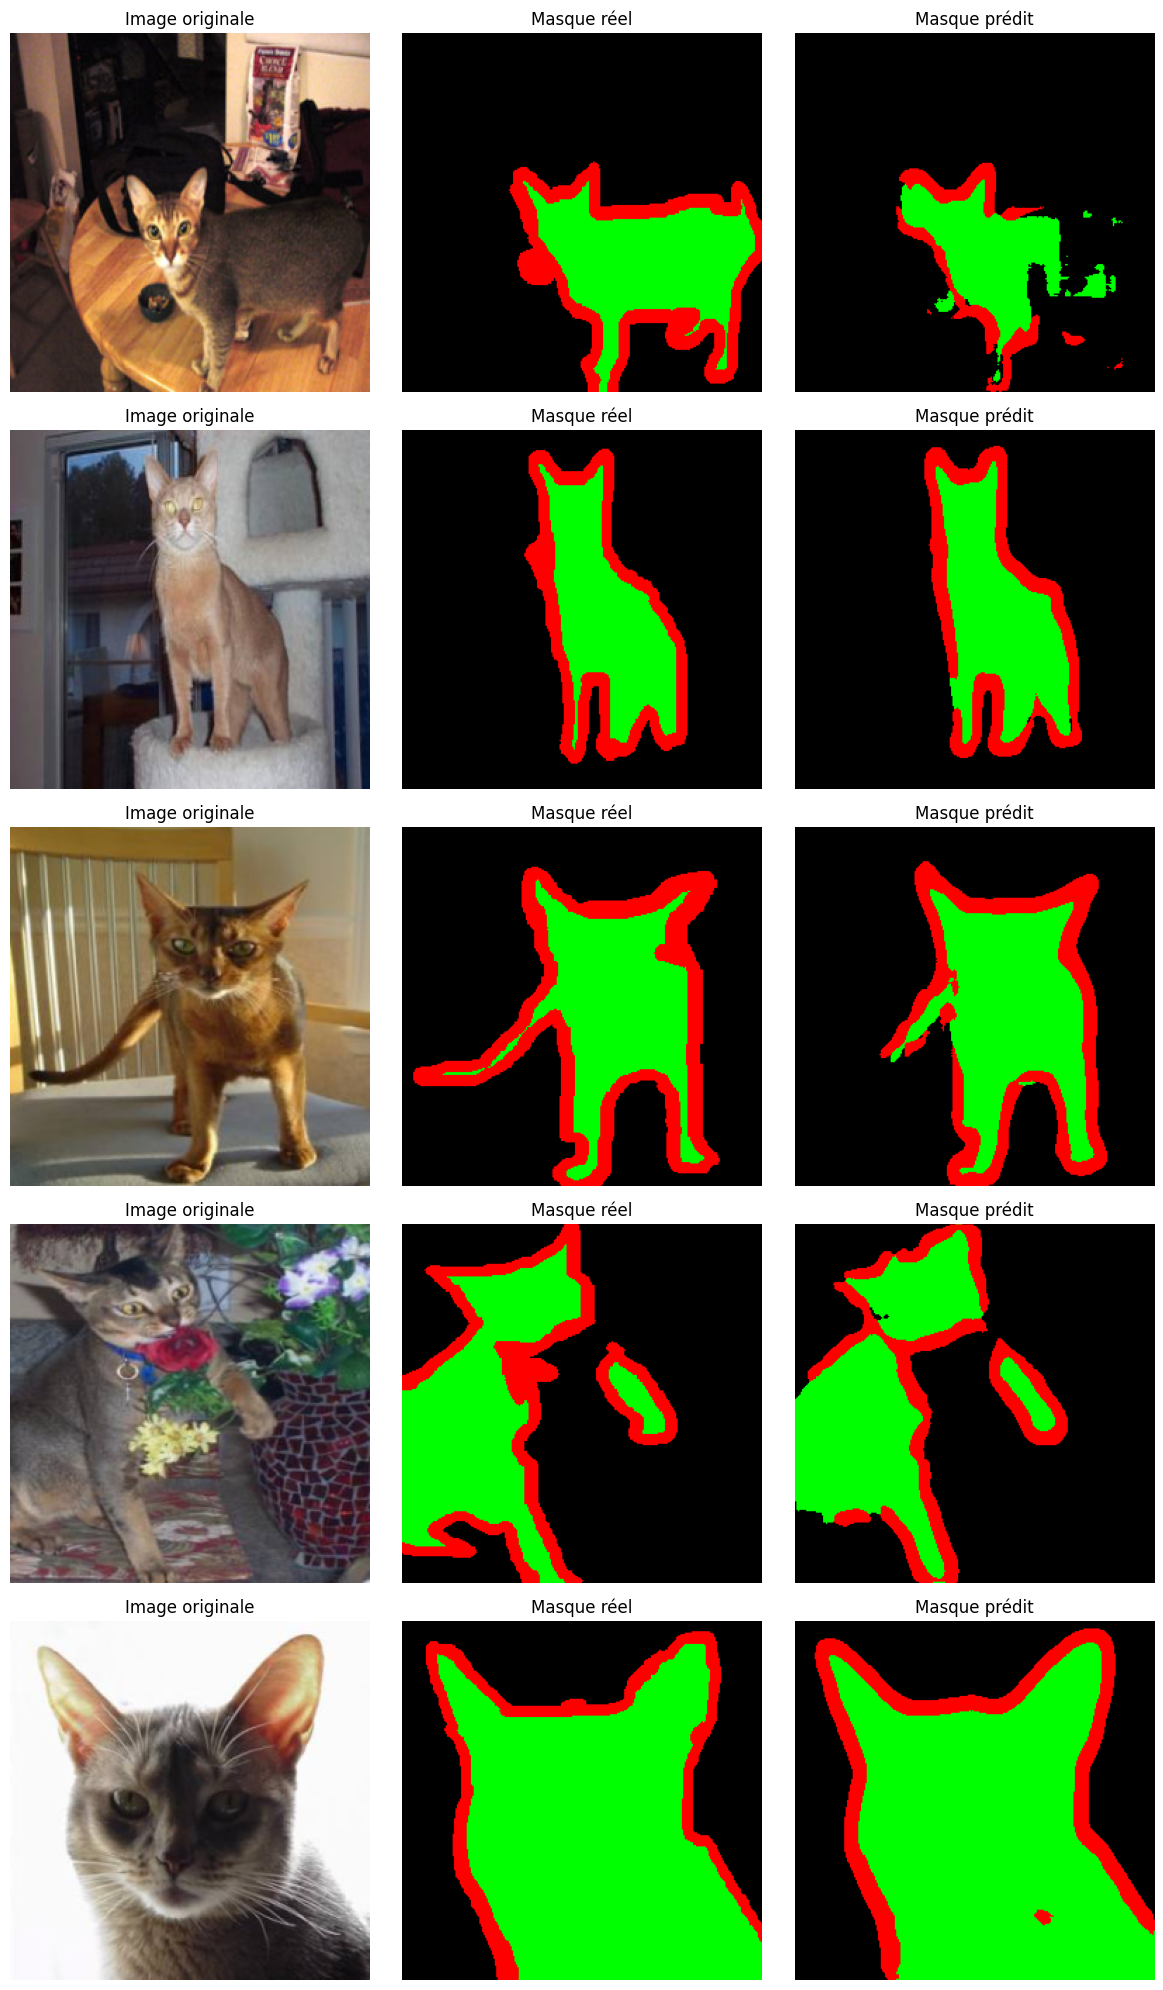

In [25]:
visualize_segmentations(model, test_loader, device, num_samples=5)

# 2- Analyse comparative:

In [31]:
def extract_breed(filename: str) -> str:
    return "_".join(filename.split("_")[:-1])

def is_cat(breed: str) -> bool:
    return breed[0].isupper()  # règle de notre dataset : Majuscule=chat, minuscule=chien


In [48]:
@torch.no_grad()
def evaluate_by_breed_segmentation(model, loader, device, num_classes=3, ignore_index=None):
    model.eval()
    breed_dice = defaultdict(list)
    breed_iou  = defaultdict(list)

    all_dice = []
    all_iou  = []

    for images, masks, filenames in loader:
        images = images.to(device)
        masks  = masks.to(device).long()

        logits = model(images)
        preds  = torch.argmax(logits, dim=1)  # [B,H,W]

        for i in range(images.size(0)):
            breed = extract_breed(filenames[i])

            pred_i = preds[i].unsqueeze(0)
            mask_i = masks[i].unsqueeze(0)

            _, _, dice_mean, iou_mean = calculate_metrics_multiclass(
                pred_i, mask_i, num_classes=num_classes, ignore_index=ignore_index
            )

            dice_mean = float(dice_mean)
            iou_mean  = float(iou_mean)

            breed_dice[breed].append(dice_mean)
            breed_iou[breed].append(iou_mean)

            all_dice.append(dice_mean)
            all_iou.append(iou_mean)

    dice_by_breed = {b: float(np.mean(v)) for b, v in breed_dice.items()}
    iou_by_breed  = {b: float(np.mean(v)) for b, v in breed_iou.items()}

    # Moyenne globale
    dice_global = float(np.mean(all_dice)) if len(all_dice) else 0.0
    iou_global  = float(np.mean(all_iou))  if len(all_iou)  else 0.0

    return dice_by_breed, iou_by_breed, dice_global, iou_global


In [46]:
dice_by_breed, iou_by_breed, dice_global, iou_global = evaluate_by_breed_segmentation(
    model, test_loader, device, num_classes=3, ignore_index=None
)

In [49]:
df_metrics = pd.DataFrame({
    "Race": list(dice_by_breed.keys()),
    "Dice": list(dice_by_breed.values()),
    "IoU":  list(iou_by_breed.values())
})

# Trier par performance Dice 
df_metrics = df_metrics.sort_values(by="Dice", ascending=True)

df_metrics = df_metrics.reset_index(drop=True)
df_metrics

,Race,Dice,IoU
0,miniature_pinscher,0.832434,0.738174
1,german_shorthaired,0.833594,0.738137
2,american_bulldog,0.839323,0.743295
3,basset_hound,0.843075,0.751028
4,japanese_chin,0.845696,0.760824
5,Persian,0.846993,0.766752
6,beagle,0.847535,0.755865
7,Sphynx,0.849554,0.759233
8,boxer,0.850444,0.758014
9,Siamese,0.850751,0.763011


In [47]:
cat_scores = [dice_by_breed[b] for b in dice_by_breed if is_cat(b)]
dog_scores = [dice_by_breed[b] for b in dice_by_breed if not is_cat(b)]

print("Dice moyen - Chats :", float(np.mean(cat_scores)))
print("Dice moyen - Chiens:", float(np.mean(dog_scores)))

cat_iou = [iou_by_breed[b] for b in iou_by_breed if is_cat(b)]
dog_iou = [iou_by_breed[b] for b in iou_by_breed if not is_cat(b)]

print("IoU moyen  - Chats :", float(np.mean(cat_iou)))
print("IoU moyen  - Chiens:", float(np.mean(dog_iou)))


Dice moyen - Chats : 0.8626113853509159
Dice moyen - Chiens: 0.8610232195857341
IoU moyen  - Chats : 0.7799841417638037
IoU moyen  - Chiens: 0.7769301191117389
